In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
import sbibm
import scipy
import time
import torch

from scipy.stats import binom_test, wilcoxon
from sbibm.utils.io import get_tensor_from_csv, get_ndarray_from_csv
from sbi.analysis import pairplot
from tensorflow import keras
from utils import compile_df, huber_loss, mean_squared_error

In [2]:
# Plotting settings
plt.style.use('plotting_settings.mplstyle')
# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Fix seed for figures.
seed = 223174 #torch.randint(1000000, (1,))
torch.manual_seed(seed)
print(f"seed {seed}")

seed 223174


In [3]:
with open("../data/results/posterior-samples-ANA-LAN-MNLE-MNLE*-all-trials-posthoc-metrics-N99.p", "rb") as fh:
    allsamples_dict = pickle.load(fh)

In [4]:
df = pd.read_csv("../data/results/df_LAN-MNLE-MNLE*-all-trials-posthoc-metrics-N99.csv")

In [5]:
df.head()

,Unnamed: 0,task,num_simulations,num_observation,algorithm,seed,C2ST,C2ST_Z,MMD,MMD_Z,...,KSD_1K,num_simulations_simulator,path,folder,num_bins,num_transforms,num_trials,ABSMEANERR,ABSVARERR,DISP
0,123,ddm,100000,1,LAN,158697878,0.50075,0.51605,0.000438,0.000222,...,NaN,1.500000e+11,/home/janfb/qode/sbibm/lan_nle_comparison/../....,0,NaN,NaN,1,0.013706,0.008523,0.998817
1,123,ddm,100000,1,MNLE,3217264884,0.50155,0.50265,0.000216,0.000054,...,NaN,1.000000e+05,/home/janfb/qode/sbibm/lan_nle_comparison/../....,0,5.0,5.0,1,0.010452,0.006986,0.995454
2,123,ddm,100000,1,MNLE*,3217264884,0.51245,0.50265,0.000216,0.000054,...,NaN,1.000000e+05,/home/janfb/qode/sbibm/lan_nle_comparison/../....,0,5.0,5.0,1,0.017242,0.007919,0.993792
3,63,ddm,100000,2,LAN,3356959328,0.50355,0.50560,0.000215,0.000133,...,NaN,1.500000e+11,/home/janfb/qode/sbibm/lan_nle_comparison/../....,1,NaN,NaN,1,0.011286,0.015090,0.980275
4,63,ddm,100000,2,MNLE,2997589923,0.51120,0.51015,0.000149,0.000101,...,NaN,1.000000e+05,/home/janfb/qode/sbibm/lan_nle_comparison/../....,1,5.0,5.0,1,0.008597,0.005772,0.979549


## Parameter recovery all trials

In [6]:
true_params, true_samples, lan_samples, nle_samples, nlee_samples, ranks, meanerr, meanerrabs, varerr, varerrabs, dispersion = allsamples_dict.values()

/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


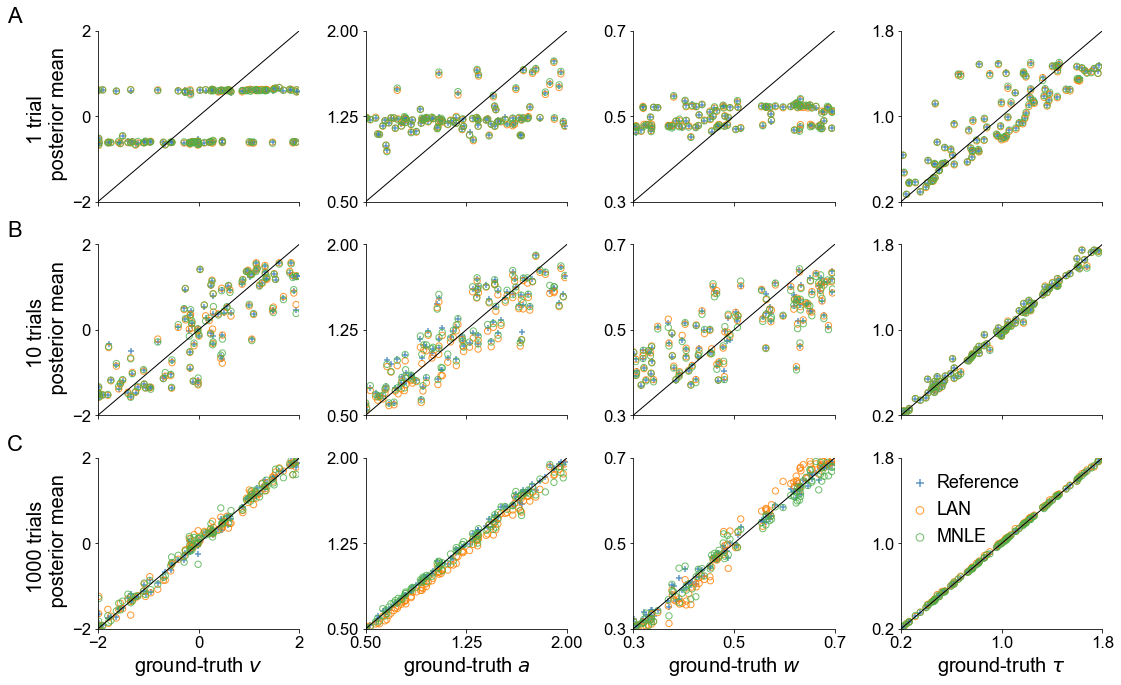

In [7]:
trials_to_show = [1, 10, 1000]
fig, ax = plt.subplots(len(trials_to_show), 4, figsize=(18, 11), 
                      gridspec_kw=dict(wspace=0.33, hspace=0.25), sharex="col")
mpl.rcParams["legend.fontsize"] = 18
s = 40
alpha=0.8
limits = [[-2, 2], [0.5, 2.], [0.3, 0.7], [0.2, 1.8]]
num_trials_list = np.array([1, 10, 100, 1000])

for jj, num_trials in enumerate(trials_to_show):
    trial_idx = np.where(num_trials_list==num_trials)[0]
    for ii in range(4):
#         truth = true_samples.mean(2)[jj, :, ii]
        truth = true_params[trial_idx, :, ii]
        plt.sca(ax[jj, ii])
        plt.scatter(truth, true_samples.mean(2)[trial_idx, :, ii], s=s, color=colors[0], 
                    label=fr"Reference",            
                    alpha=alpha,
#                     facecolors='none'
                    marker="+",
                   )
        plt.scatter(truth, lan_samples.mean(2)[trial_idx, :, ii], s=s, color=colors[1], 
                    label=fr"LAN",            
                    alpha=alpha,
                    facecolors='none'
                   )
        plt.scatter(truth, nle_samples.mean(2)[trial_idx, :, ii], s=s, color=colors[2], 
                    label=fr"MNLE",
                    alpha=alpha,     
                    facecolors='none'
                   )
        
        plt.plot(np.linspace(limits[ii][0], limits[ii][1], 100), 
                 np.linspace(limits[ii][0], limits[ii][1], 100), color="k", lw=1)
        plt.ylim(limits[ii])
        plt.yticks(np.linspace(limits[ii][0], limits[ii][1], 3))

        plt.xlim(limits[ii])
        plt.xticks(np.linspace(limits[ii][0], limits[ii][1], 3))
        if jj==2:
            plt.xlabel("ground-truth " + [r"$v$", r"$a$", r"$w$", r"$\tau$"][ii])
        
        if ii==0:
            plt.ylabel(f"{num_trials} trial{'s' if jj>0 else ''} \n posterior mean")
            
        if ii==3 and jj==2:
            plt.legend(loc=2, markerscale=1.2, handlelength=0.3, frameon=False);

weight = "regular"
fontsize = 22
y1 = 0.89
x1 = 0.055
dx = 0.0
dy = 0.27
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1, y1-2*dy, "C", fontsize=fontsize, fontweight=weight)
fig.text(x1+dx, y1-dy, "B", fontsize=fontsize, fontweight=weight)
# fig.text(x1+dx, y1-3*dy, "D", fontsize=fontsize, fontweight=weight)            
            
plt.tight_layout();
fig.savefig("MNLE-LAN-parameter-recovery-over-trials.png", dpi=300, bbox_inches="tight");

## Metric over trials

In [8]:
df[df.num_trials==1000].groupby("algorithm").C2ST.median()

algorithm
LAN      0.97260
MNLE     0.84815
MNLE*    0.84470
Name: C2ST, dtype: float64

In [9]:
df[df.num_trials==1000].groupby("algorithm").MEANERR.median()

algorithm
LAN      2.194919
MNLE     1.107177
MNLE*    0.712362
Name: MEANERR, dtype: float64

In [10]:
df[df.num_trials==1000].groupby("algorithm").VARERR.median()

algorithm
LAN      0.321227
MNLE     0.362627
MNLE*    1.411706
Name: VARERR, dtype: float64

In [11]:
df[df.num_trials==1000].groupby("algorithm").ABSMEANERR.median()

algorithm
LAN      0.032239
MNLE     0.022590
MNLE*    0.014849
Name: ABSMEANERR, dtype: float64

In [12]:
df[df.num_trials==1000].groupby("algorithm").ABSVARERR.median()

algorithm
LAN      0.000248
MNLE     0.000264
MNLE*    0.001260
Name: ABSVARERR, dtype: float64

/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:396: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:396: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:396: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:396: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


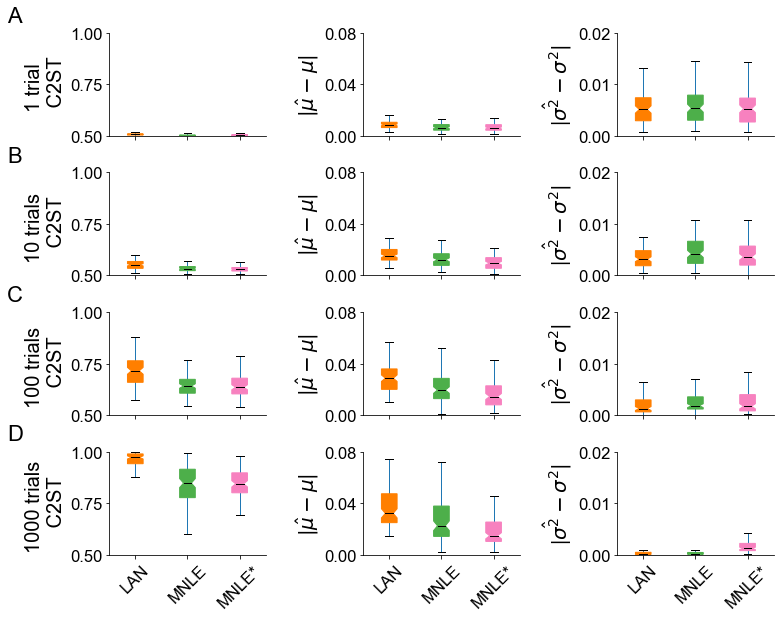

In [13]:
ylabels = ["C2ST", r"$|\hat{\mu} - \mu|$", r"|$\hat{\sigma^2} - \sigma^2|$"]
box_widths = [0.3] * 3
showfliers = False
notch = True

fig, ax2 = plt.subplots(4, 3, figsize=(11, 9), sharey="col", sharex=True)

for idx, num_trials in enumerate(num_trials_list):
    d = df[df.num_trials == num_trials]
    
    bdict = d.boxplot(column=["C2ST", "ABSMEANERR", "ABSVARERR"], 
                    ax=ax2[idx, :],
                    by=["algorithm"],
                    grid=False, 
                    widths=box_widths,
                    notch=notch, 
                    patch_artist=True,
                    showfliers=showfliers,
                    return_type="both",
                    medianprops=dict(color="k"),
              );
    ticks = [[0.5, 1.0], [0, .08], [0., .02]]
    for ii in range(3):
        plt.sca(ax2[idx, ii])
        plt.xlabel("")
        plt.title("")
        if ii==0:
            plt.ylabel(f"{[1, 10, 100, 1000][idx]} trial{'s' if idx>0 else ''} \n {ylabels[ii]}")
        else:
            plt.ylabel(ylabels[ii])
        
        if ii < 2:
            plt.yticks(np.linspace(ticks[ii][0], ticks[ii][1], 3))
            plt.ylim(*ticks[ii])
        else:
            plt.yticks(np.linspace(ticks[ii][0], ticks[ii][1], 3 if idx < 3 else 3))
            plt.ylim(*ticks[ii])

        if idx == 3:
            plt.xticks([1, 2, 3], ["LAN", "MNLE", "MNLE*"], rotation=45)
    plt.suptitle("")
    ii = 0
    for row_key, (axi,row) in bdict.iteritems():
        ii += 1
        for i,box in enumerate(row['boxes']):
            box.set_color(colors[i+1])

weight = "regular"
fontsize = 22
y1 = 0.94
x1 = 0.005
dx = 0.0
dy = 0.215
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1, y1-2*dy, "C", fontsize=fontsize, fontweight=weight)
fig.text(x1+dx, y1-dy, "B", fontsize=fontsize, fontweight=weight)
fig.text(x1+dx, y1-3*dy, "D", fontsize=fontsize, fontweight=weight)
# fig.text(x1, y1-0.53, "C", fontsize=fontsize, fontweight=weight)

plt.tight_layout();
fig.savefig("MNLE-LAN-posterior-metrics-over-trials.png", dpi=300, bbox_inches="tight");

## SBC over trials

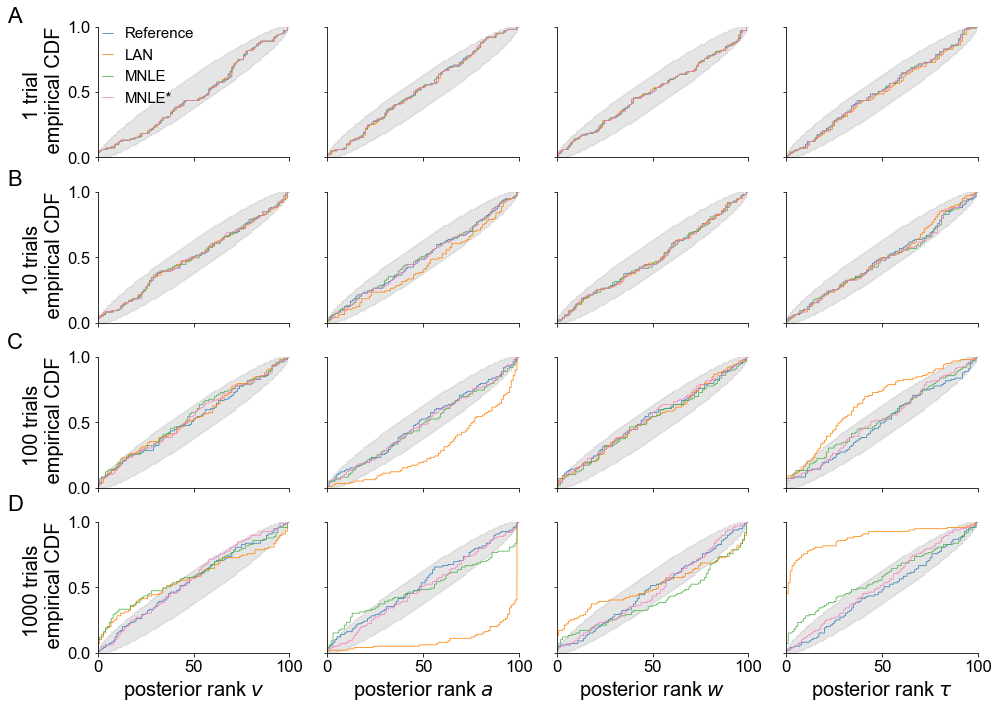

In [14]:
fig, ax1 = plt.subplots(4, 4, figsize=(14, 10), sharey=True, sharex=True)
mpl.rcParams["legend.fontsize"] = 15
mpl.rcParams["font.size"] = 18
num_methods = 4
notch = True
showfliers = False
labels = ["Reference", "LAN", "MNLE", "MNLE*"]
s = 20
alpha=0.8
limits = [[-2, 2], [0.5, 2.], [0.3, 0.7], [0.2, 1.8]]
repeats = 50
nbins = 100
N = 99

from scipy.stats import binom

for kk in range(len(num_trials_list)):
    for ii in range(num_methods):
        for jj in range(4):
            plt.sca(ax1[kk, jj])
            hist, *_ = np.histogram(ranks[kk, :, jj, ii], bins=nbins, density=False)
            histcs = hist.cumsum()
            plt.plot(np.linspace(0, nbins, repeats*nbins), 
                     np.repeat(histcs / histcs.max(), repeats), 
                     label=labels[ii], 
                     color=colors[:num_methods][ii], 
                     alpha=1., 
                     lw=.75)
            if jj==0:
                plt.yticks(np.linspace(0, 1, 3))
                plt.ylabel(f"{[1, 10, 100, 1000][kk]} trial{'s' if kk>0 else ''} \n empirical CDF")
                if kk == 0:
                    plt.legend(loc=2, markerscale=1., handlelength=0.75, bbox_to_anchor=(-.05, 1.1))
            else:
                plt.yticks(np.linspace(0, 1, 3), np.linspace(0, 1, 3))
            plt.ylim(0, 1)
            plt.xlim(0, nbins)
            plt.xticks(np.linspace(0, nbins, 3))
            if kk == 3:
                plt.xlabel("posterior rank " + [r"$v$", r"$a$", r"$w$", r"$\tau$"][jj])
            if ii==0:
                # Construct uniform histogram.
                hb = binom(N, p=1 / nbins).ppf(0.5) * np.ones(nbins)
                hbb = hb.cumsum() / hb.sum()

                lower = [binom(N, p=p).ppf(0.005) for p in hbb]
                upper = [binom(N, p=p).ppf(0.995) for p in hbb]

                # Plot grey area with expected ECDF.
                plt.fill_between(x=np.linspace(0, nbins, repeats*nbins), 
                             y1=np.repeat(lower / np.max(lower), repeats), 
                             y2=np.repeat(upper / np.max(lower), repeats), 
                             color="grey", 
                             alpha=0.2)
weight = "regular"
fontsize = 22
y1 = 0.97
x1 = 0.004
dx = 0.0
dy = 0.226
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1, y1-2*dy, "C", fontsize=fontsize, fontweight=weight)
fig.text(x1+dx, y1-dy, "B", fontsize=fontsize, fontweight=weight)
fig.text(x1+dx, y1-3*dy, "D", fontsize=fontsize, fontweight=weight)
# fig.text(x1, y1-0.53, "C", fontsize=fontsize, fontweight=weight)

plt.tight_layout();
fig.savefig("MNLE-LAN-sbc-over-trials.png", dpi=300, bbox_inches="tight");